# 导包

In [1]:
#导包
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,Multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
# calculate RMSE
from tensorflow.keras.losses import MeanSquaredError
from math import sqrt
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用 GPU 1
# from model import create_model
from evaluate import look_loss
from evaluate import all_estimate

gc.collect()

2025-04-23 18:24:37.404657: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 18:24:38.222161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745403878.601790   24641 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745403878.695360   24641 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745403879.181078   24641 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

23

# 数据处理

In [ ]:
depth = [5.1, 18.5, 40.3, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4]
data_st_processed = np.load(r'./data_st_processed.npy')
data_surface_processed = np.load(r'./data_surface_processed.npy')
data_surface = data_surface_processed

data_input = data_surface

data_st = data_st_processed[0:132,:,:,:]
data_underwater1 = np.load(r'./with_noise/rate95_5/layer1_pred_data.npy')
data_underwater2 = np.load(r'./with_noise/rate95_5/layer2_pred_data.npy')
data_underwater3 = np.load(r'./with_noise/rate95_5/layer3_pred_data.npy')
data_underwater4 = np.load(r'./with_noise/rate95_5/layer4_pred_data.npy')
data_underwater5 = np.load(r'./with_noise/rate95_5/layer5_pred_data.npy')
data_underwater6 = np.load(r'./with_noise/rate95_5/layer6_pred_data.npy')
data_underwater7 = np.load(r'./with_noise/rate95_5/layer7_pred_data.npy')
data_underwater8 = np.load(r'./with_noise/rate95_5/layer8_pred_data.npy')
data_underwater9 = np.load(r'./with_noise/rate95_5/layer9_pred_data.npy')
data_underwater10 = np.load(r'./with_noise/rate95_5/layer10_pred_data.npy')
data_underwater11 = np.load(r'./with_noise/rate95_5/layer11_pred_data.npy')
data_underwater12 = np.load(r'./with_noise/rate95_5/layer12_pred_data.npy')
data_underwater13 = np.load(r'./with_noise/rate95_5/layer13_pred_data.npy')
data_underwater = np.concatenate((data_underwater1, data_underwater2,data_underwater3,data_underwater4,data_underwater5,data_underwater6,data_underwater7,data_underwater8
                                  ,data_underwater9,data_underwater10,data_underwater11,data_underwater12,data_underwater13), axis=-1)
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[:,:,:,13:14] #(132,  100，160， 1)
print(out_data_y.shape)

(132, 108, 168, 5) (132, 100, 160, 20)
(132, 100, 160, 1)


In [3]:
print('----------------for layer14_ST--------------------')

time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

----------------for layer14_ST--------------------
(132, 100, 160, 9, 9, 18)


In [4]:
# 修改变量形状
out_data_reshape = out_data.reshape((132,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
# nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,channel-1:channel]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)
    

(132, 16000, 9, 9, 18)
(132, 16000, 9, 9, 18)
(16000, 81)


In [5]:
out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
print('out_data_y_reshape:',out_data_y_reshape.shape)
out_data_y_reshape = out_data_y_reshape.reshape(-1,132,1)
print('out_data_y_reshape:',out_data_y_reshape.shape)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于1时
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)
    

out_data_reshape: (16000, 132, 9, 9, 18)
out_data_y_reshape: (100, 160, 132, 1)
out_data_y_reshape: (16000, 132, 1)


In [6]:
print(nan_mask2)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [7]:
nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]


In [8]:
out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

In [9]:
out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)

# 最后十二个月的数据作为test
test_num = 120
x_train = out_data_reshape[:test_num]
y_train = out_data_y_reshape[:test_num]

x_test = out_data_reshape[test_num:]
y_test = out_data_y_reshape[test_num:]

# 将前两个维度进行合并  时间*(lat*lon)
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))

y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=100)

out_data_reshape: (132, 14783, 9, 9, 18)
out_data_y_reshape: (132, 14783, 1)


In [10]:
# 记录数据集的形状
x_train_shape = x_train.shape
y_train_shape = y_train.shape

x_test_shape = x_test.shape
y_test_shape = y_test.shape

x_val_shape = x_val.shape
y_val_shape = y_val.shape


In [11]:
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train_shape[3])) 
x_test = scaler_f.transform(x_test.reshape(-1,x_test_shape[3]))
x_val = scaler_f.transform(x_val.reshape(-1,x_val_shape[3]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,y_train_shape[1])) 
y_test = scaler_l.transform(y_test.reshape(-1,y_test_shape[1])) 
y_val = scaler_l.transform(y_val.reshape(-1,y_val_shape[1])) 

In [12]:
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))
x_val = np.reshape(x_val,(-1,9,9,channel))
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))
y_val = np.reshape(y_val,(-1,1))

# 模型训练

# 无注意力机制

In [13]:
def create_model(neurons1, neurons2):
    # 第一部分输入
    model_input = Input(shape=x_train.shape[1:3] + (5,))
    x = Conv2D(filters=neurons1, kernel_size=(3, 3), strides=1)(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv2D(filters=neurons2, kernel_size=(3, 3), strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Flatten()(x)
    x = Dense(units=64, activation='relu')(x)
    # x = Dense(units=16, activation='relu')(x)

    # 第二部分输入
    model_input2 = Input(shape=x_train.shape[1:3] + (13,))


    # 第二部分卷积网络
    x1 = Conv2D(filters=32, kernel_size=(3, 3), strides=1)(model_input2)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Conv2D(filters=64, kernel_size=(3, 3), strides=1)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Flatten()(x1)
    x1 = Dense(units=8, activation='relu')(x1)
    # x1 = Dense(units=16, activation='relu')(x1)
    
    # 正确写法（方法1）
    concatenated = Concatenate(axis=-1)([
        Lambda(lambda x: 0.95 * x)(x),
        Lambda(lambda x: 0.05 * x)(x1)
    ])

    # 后续层
    # concatenated = Dense(32, activation='relu')(concatenated)
    concatenated = Dense(units=32, activation='relu')(concatenated)
    concatenated = Dense(units=16, activation='relu')(concatenated)
    

    # # 输出层
    out = Dense(units=1)(concatenated)
    
    # out = Dense(units=1)(x1)
    

    # 创建模型
    model = Model(inputs=[model_input, model_input2], outputs=out)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# 创建模型
model = create_model(128, 256)

# 回调函数
checkpoint_path = 'layer14_no_95_5/CNN_model_layer14_st_no.keras'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


# 训练模型
num_epochs = 200
batch_size = 2048
# history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:18]], y_train,
                    # validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:18]], y_val),
                    # epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=[keras_callbacks, OutputCallback()])
                    
history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:18]], y_train,
                    validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:18]], y_val),
                    epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=keras_callbacks)

I0000 00:00:1745404212.221355   24641 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9


Epoch 1/200


I0000 00:00:1745404260.098473   25069 service.cc:152] XLA service 0x7f72ec02eaa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745404260.103717   25069 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-04-23 18:31:00.797756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745404262.297380   25069 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-23 18:31:06.631096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3489', 144 bytes spill stores, 144 bytes spill loads

2025-04-23 18:31:06.906265: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

607/607 - 71s - 117ms/step - loss: 0.0459 - val_loss: 0.0227
Epoch 2/200
607/607 - 19s - 31ms/step - loss: 0.0194 - val_loss: 0.0255
Epoch 3/200
607/607 - 19s - 32ms/step - loss: 0.0167 - val_loss: 0.0183
Epoch 4/200
607/607 - 20s - 32ms/step - loss: 0.0157 - val_loss: 0.0164
Epoch 5/200
607/607 - 19s - 31ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 6/200
607/607 - 20s - 32ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 7/200
607/607 - 19s - 32ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 8/200
607/607 - 20s - 32ms/step - loss: 0.0149 - val_loss: 0.0153
Epoch 9/200
607/607 - 19s - 32ms/step - loss: 0.0145 - val_loss: 0.0166
Epoch 10/200
607/607 - 19s - 32ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 11/200
607/607 - 19s - 32ms/step - loss: 0.0143 - val_loss: 0.0160
Epoch 12/200
607/607 - 19s - 32ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 13/200
607/607 - 19s - 32ms/step - loss: 0.0140 - val_loss: 0.0161
Epoch 14/200
607/607 - 19s - 32ms/step - loss: 0.0140 - val_loss: 0.015

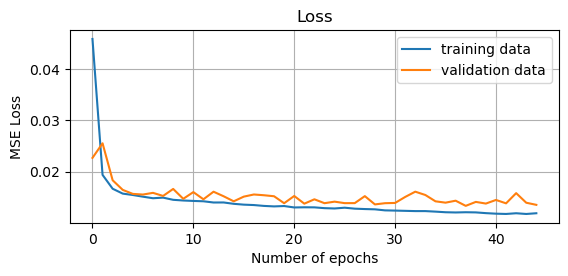

5544/5544 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step
Test RMSE: 0.199
acc: 98.08181
R² score: 0.9604493975639343


In [14]:
look_loss(history)
best_model1 = tf.keras.models.load_model('layer14_no_95_5/CNN_model_layer14_st_no.keras',      safe_mode=False)
all_estimate(best_model1,[x_test[:,:,:,0:5], x_test[:,:,:,5:18]], y_test)#x_test[:,:,:,0:5], x_test[:,:,:,5:18], y_test

In [15]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer14_no_95_5/CNN_model_layer14_st_no.keras',      safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:18]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer14_st = scaler_l.inverse_transform(result)
y_test_layer14_unscaled = scaler_l.inverse_transform(y_test)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step


In [16]:
r2 = r2_score(y_test_layer14_unscaled[:,0],predict_layer14_st[:,0])
print('layer14 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer14_unscaled[:,0]-predict_layer14_st[:,0])))
print('layer14 Test mae: %.3f' % mae)

layer14 R² score: 0.9604493379592896
layer14 Test mae: 0.470


Results written to results.txt
[[10.4224062  10.49299908 10.50095749 ...  9.02417755  8.95866489
   8.82860184]
 [10.84484959 10.730793   10.6723671  ...  9.1913662   9.19236183
   9.12712288]
 [11.11622524 11.02839375 10.97556019 ...  9.39522362  9.36780548
   9.38298512]
 ...
 [ 1.20064616  1.19407344  1.2317512  ...  8.28481102  8.38402081
   8.33046532]
 [ 1.14011931  1.07075095  1.09254241 ...  7.46787071  7.49346733
   7.45999193]
 [        nan         nan  0.9656294  ...  6.50680542  6.51612759
   6.46508598]]


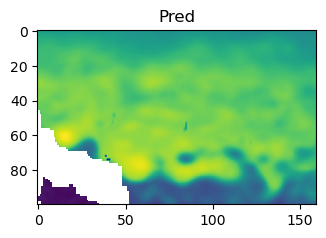

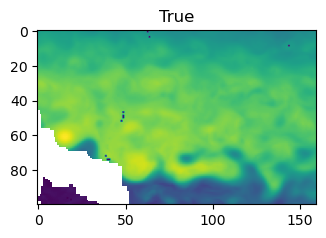

[[10.11441422 10.21036434 10.31656837 ...  9.34095287  9.29993629
   9.15930653]
 [10.46159267 10.57512093 10.69157982 ...  9.52333164  9.49989319
   9.37244797]
 [10.69890404 10.82195473 10.95379543 ...  9.68739891  9.71083736
   9.60756207]
 ...
 [ 0.61095029  0.57432729  0.56846792 ...  8.03207493  8.2562027
   8.34995556]
 [ 0.39414579  0.33701497  0.39561063 ...  7.18317223  7.31427956
   7.34504223]
 [        nan         nan  0.26084119 ...  6.4170351   6.46464443
   6.45292568]]


6188

In [17]:
predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer14_st
true_data[non_nan_mask] = y_test_layer14_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer14_no_95_5/results.txt", "w") as file:
    file.write(f"layer14 R² score: {r2}\n")
    file.write(f"layer14 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer14_no_95_5/predict_data.npy',predict_data)
np.save(r'./layer14_no_95_5/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()